# Database

In [1]:
# Imports
from models import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
# seed
np.random.seed(2020)

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

Load and prepare Breast Cancer database, located in ```../database/```.

In [2]:
# Column names
col_names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]
# Reading dataset
dataset = pd.read_csv('../dataset/wdbc.data', header=None, names= col_names)
X = dataset.drop(['id','diagnosis'], axis=1)
y = dataset['diagnosis']

We define a function that separates and organizes the dataset in classes.

In [3]:
def separate_in_classes(X, y):
    return (X[y == 'B'], X[y == 'M'])

# Constants

In [4]:
# Ammount of samples
n_samples = X.shape[0]
# Observed space dimensionality
data_dim = X.shape[1]
# Ammount of classes
n_classes = len(y.unique())
# Hidden representation dimension
h_dim = 3

# Learning

Create `BayesianGaussianMixture` object from [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html), with a number of components equal to the ammount of classes.

The parameter `weight_concentration_prior_type` models if a Dirichlet distribution or a Dirichlet Process is used for the weights. In this case, we model using a distribution. 

The following prior values are used:
- The means variable $\mu$ follows a centered normal distribution: 
  $$\mu_k \sim \mathcal{N}_{data\_dim}(0,I).$$
- The precision variables $\Lambda$ follow a Wishart distribution with parameters
  $$\Lambda_k \sim \mathcal{W}_{data\_dim}(data\_dim, I).$$
  The covariance matrix are restricted to diagonal matrices.
- The weights concentration variable follows a dirichlet with parameter
  $$ \pi \sim \text{Symmetric-Dirichlet}\Big(\frac{1}{n\_classes}\Big).$$
    

In [5]:
def gm_model(n_classes, dim):
    return BayesianGaussianMixture(n_components = n_classes, 
                                   weight_concentration_prior_type = 'dirichlet_distribution',
                                   weight_concentration_prior = 1/n_classes,
                                   covariance_type = "diag",
                                   mean_precision_prior = 1,
                                   mean_prior = np.zeros([dim]),
                                   degrees_of_freedom_prior = dim,
                                   covariance_prior = np.ones(dim),
                                   max_iter = 1000,
                                   tol = 1e-3,
                                   random_state = 0)


# Learning and results in observed space

We fit the model using the observed data `X`. The stop criteria is either reaching `max_iter` steps on the EM algorithm or having a lower bound difference betweeen iterations below `tol`.

In [6]:
gm = gm_model(n_classes, data_dim)
gm.fit(X)

BayesianGaussianMixture(covariance_prior=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
                        covariance_type='diag', degrees_of_freedom_prior=30,
                        max_iter=1000, mean_precision_prior=1,
                        mean_prior=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
                        n_components=2, random_state=0,
                        weight_concentration_prior=0.5,
                        weight_concentration_prior_type='dirichlet_distribution')

The model's posterior parameters might be inspected via `weights_`, `means_` and `precisions_`

The mixture weights are:

In [7]:
print(gm.weights_)

[0.31003524 0.68996476]


Each component mean is:

In [8]:
print(gm.means_)

[[1.80877281e+01 2.14089970e+01 1.19737761e+02 1.05037966e+03
  1.02204868e-01 1.51449044e-01 1.75581900e-01 9.40103080e-02
  1.92956780e-01 6.23897315e-02 6.69248696e-01 1.23638447e+00
  4.73808471e+00 8.16162460e+01 6.87003760e-03 3.55331308e-02
  4.85362265e-02 1.61056782e-02 2.10839782e-02 4.52242746e-03
  2.19285046e+01 2.87626885e+01 1.46898877e+02 1.53042711e+03
  1.42144264e-01 3.82424356e-01 4.71284354e-01 1.87096231e-01
  3.18735105e-01 9.06549634e-02]
 [1.22731508e+01 1.82378670e+01 7.90046485e+01 4.73572974e+02
  9.32405213e-02 8.26101232e-02 4.92919277e-02 2.83774732e-02
  1.74933460e-01 6.26622272e-02 2.84266880e-01 1.20188314e+00
  2.00900017e+00 2.15545776e+01 7.08214982e-03 2.08235011e-02
  2.42417908e-02 9.79672192e-03 2.01941828e-02 3.44820867e-03
  1.36395924e+01 2.41581998e+01 8.88775610e+01 5.83649306e+02
  1.27296770e-01 1.95295721e-01 1.81203231e-01 8.14001156e-02
  2.75704101e-01 8.05000165e-02]]


Each component diagonal covariance matrix is:

In [9]:
print(gm.covariances_)

[[9.47840075e+00 1.58435667e+01 4.32172614e+02 1.13363388e+05
  5.03599175e-03 7.49654076e-03 1.00867762e-02 5.81867353e-03
  5.73159426e-03 4.92783359e-03 1.09317677e-01 2.27032117e-01
  5.86972030e+00 3.44034339e+03 4.85821404e-03 5.22862523e-03
  6.25116677e-03 4.88643542e-03 4.94554941e-03 4.85922191e-03
  1.69222718e+01 3.24804387e+01 7.93101592e+02 3.08047808e+05
  5.38100190e-03 3.22832394e-02 3.97253436e-02 6.81410246e-03
  1.02745275e-02 5.30736745e-03]
 [3.23339023e+00 1.59768110e+01 1.42690450e+02 1.69305091e+04
  2.56180776e-03 3.50401709e-03 3.77670897e-03 2.68261905e-03
  3.00672733e-03 2.41382134e-03 1.26565377e-02 3.09473211e-01
  5.19382493e-01 6.70067940e+01 2.37457252e-03 2.55293586e-03
  2.74115687e-03 2.38877417e-03 2.41320525e-03 2.37088951e-03
  4.52100195e+00 3.18931681e+01 2.11185765e+02 2.97868499e+04
  2.82649593e-03 1.24249015e-02 1.98532862e-02 4.04550450e-03
  4.72400902e-03 2.58482299e-03]]


The dataset is split between the two classes

In [10]:
(B, M) = separate_in_classes(X,y)

`predict_proba(p)` gives the probability of`p` belonging to each component. In particular, this shows that the benign case, domostly belong to the second component.

In [11]:
gm.predict_proba(B)

array([[3.59337824e-13, 1.00000000e+00],
       [4.73580532e-14, 1.00000000e+00],
       [1.31440689e-18, 1.00000000e+00],
       [2.92266061e-16, 1.00000000e+00],
       [8.66633303e-17, 1.00000000e+00],
       [1.05953964e-15, 1.00000000e+00],
       [3.24085367e-12, 1.00000000e+00],
       [4.41374073e-16, 1.00000000e+00],
       [1.85871471e-14, 1.00000000e+00],
       [2.98225129e-17, 1.00000000e+00],
       [7.20782864e-17, 1.00000000e+00],
       [5.62343980e-15, 1.00000000e+00],
       [1.13378464e-17, 1.00000000e+00],
       [3.28533357e-15, 1.00000000e+00],
       [2.26564449e-16, 1.00000000e+00],
       [7.12762571e-17, 1.00000000e+00],
       [8.74669090e-17, 1.00000000e+00],
       [2.97768429e-17, 1.00000000e+00],
       [9.99993914e-01, 6.08603437e-06],
       [1.32824684e-16, 1.00000000e+00],
       [1.94287271e-14, 1.00000000e+00],
       [7.03754741e-16, 1.00000000e+00],
       [5.46079237e-14, 1.00000000e+00],
       [7.37390805e-15, 1.00000000e+00],
       [1.104606

This might be shown using `plot_mixture_distplot`. It shows a Gaussian aproximation of the histogram constructed with component probabilities. 

<Figure size 432x288 with 0 Axes>

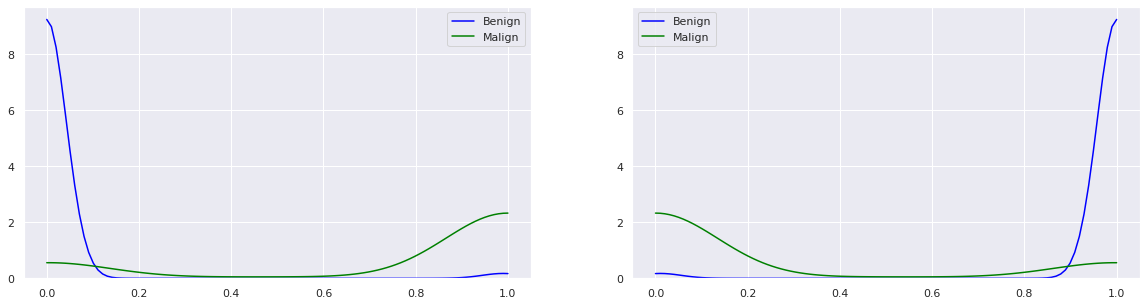

In [12]:
plot_mixture_distplot([gm.predict_proba(B), gm.predict_proba(M)], ["Benign", "Malign"], ["blue","green"], 
                      n_components = n_classes)

# Reduced example

The same procedure is now done under a lower dimensional representation of the data. A Variational auto-encoder is used.

In [13]:
vae_model = vae(h_dim, 100, data_dim)
q_vae = Q_vae(h_dim, 100, data_dim)

optimizer = tf.train.AdamOptimizer(0.01)
VI_vae = inf.inference.VI(q_vae, optimizer=optimizer, epochs=4000)
vae_model.fit({"x": X}, VI_vae)
data = vae_model.posterior("z", data={"x": X}).sample()


 0 epochs	 470867424.0....................
 200 epochs	 3197044.75....................
 400 epochs	 1792793.375....................
 600 epochs	 1376183.875....................
 800 epochs	 876444.0625....................
 1000 epochs	 822838.1875....................
 1200 epochs	 609006.8125....................
 1400 epochs	 532017.3125....................
 1600 epochs	 473997.46875....................
 1800 epochs	 397521.09375....................
 2000 epochs	 359422.46875....................
 2200 epochs	 316790.09375....................
 2400 epochs	 303690.5....................
 2600 epochs	 432957.375....................
 2800 epochs	 247502.03125....................
 3000 epochs	 226644.484375....................
 3200 epochs	 215084.109375....................
 3400 epochs	 252918.125....................
 3600 epochs	 197283.46875....................
 3800 epochs	 175206.21875....................

We are now able to plot the data we are trying to fit into two Gaussian distributions.

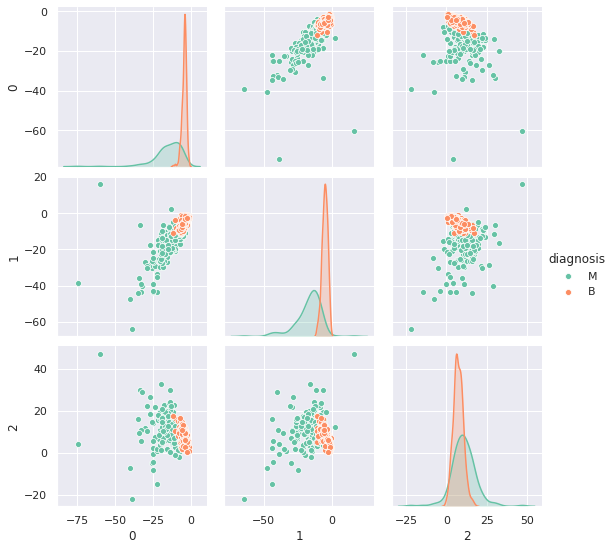

In [14]:
print_posterior(data, y)

Define and train the mixture model.

In [15]:
gm = gm_model(n_classes, h_dim)
gm.fit(data)

BayesianGaussianMixture(covariance_prior=array([1., 1., 1.]),
                        covariance_type='diag', degrees_of_freedom_prior=3,
                        max_iter=1000, mean_precision_prior=1,
                        mean_prior=array([0., 0., 0.]), n_components=2,
                        random_state=0, weight_concentration_prior=0.5,
                        weight_concentration_prior_type='dirichlet_distribution')

The learned mean values can be shown. One may notice that the first component seeks to model the malign points and the second the benign ones, using its mean value and the above graph.

In [16]:
gm.means_

array([[-15.92204264, -17.70295155,  11.35885255],
       [ -4.46838806,  -5.41635171,   7.37562395]])

We are plotting the same distplot for this results.

In [17]:
(B, M) = separate_in_classes(data,y)

<Figure size 432x288 with 0 Axes>

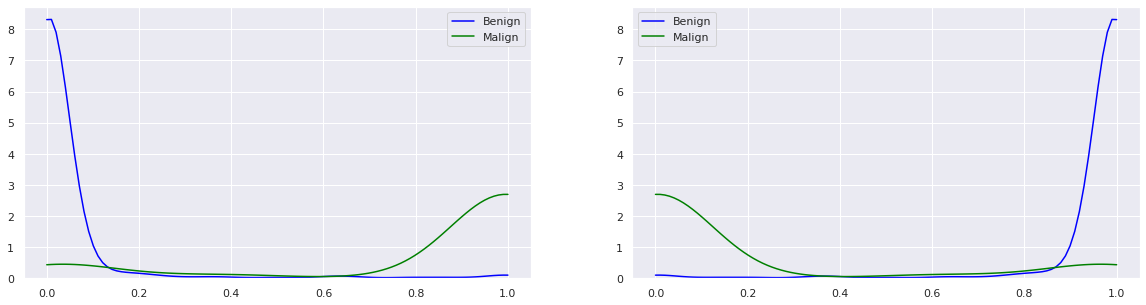

In [18]:
plot_mixture_distplot([gm.predict_proba(B), gm.predict_proba(M)], ["Benign", "Malign"], ["blue","green"], 
                      n_components = n_classes)